In [18]:
import pandas as pd 
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
db = pymysql.connect(
    host='localhost',
    user='root',
    password='adi',
    database='ecommerce'
)
cur = db.cursor()

# Basic Queries

## 1. List all unique cities where customers are located.

In [3]:
query = "SELECT DISTINCT customer_city FROM customers"

cur.execute(query)
data = cur.fetchall()
data

(('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

## 2. Count the number of orders placed in 2017.

In [4]:
query = "SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017" # using year function , similarly can use HOUR,TIME,MONTH

cur.execute(query)
data = cur.fetchall()
print(data)
# or we can do
print(data[0][0])

((45101,),)
45101


## 3. Find the total sales per category.


In [5]:
query = """SELECT UPPER(p.product_category),ROUND(SUM(payments.payment_value),2) AS total_sales
FROM order_items AS o
JOIN products AS p
ON o.product_id = p.product_id
JOIN payments
ON payments.order_id = o.order_id
GROUP BY p.product_category
ORDER BY total_sales DESC
;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category","Total Sales"])
df

,Category,Total Sales
0,BED TABLE BATH,1712553.67
1,HEALTH BEAUTY,1657373.12
2,COMPUTER ACCESSORIES,1585330.45
3,FURNITURE DECORATION,1430176.39
4,WATCHES PRESENT,1429216.68
...,...,...
69,PC GAMER,2174.43
70,HOUSE COMFORT 2,1710.54
71,CDS MUSIC DVDS,1199.43
72,FASHION CHILDREN'S CLOTHING,785.67


## 4. Calculate the percentage of orders that were paid in installments.


In [6]:
query = """SELECT 
SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)/COUNT(*)*100 AS installment_percentage
FROM payments;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["installment_percentage"])
df

,installment_percentage
0,99.9981


## 5. Count the number of customers from each state. 


In [7]:
query = """SELECT customer_state, COUNT(customer_id) FROM customers
GROUP BY customer_state;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Customer State","Customer Count"])
df

,Customer State,Customer Count
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852
5,RS,5466
6,PA,975
7,GO,2020
8,ES,2033
9,BA,3380


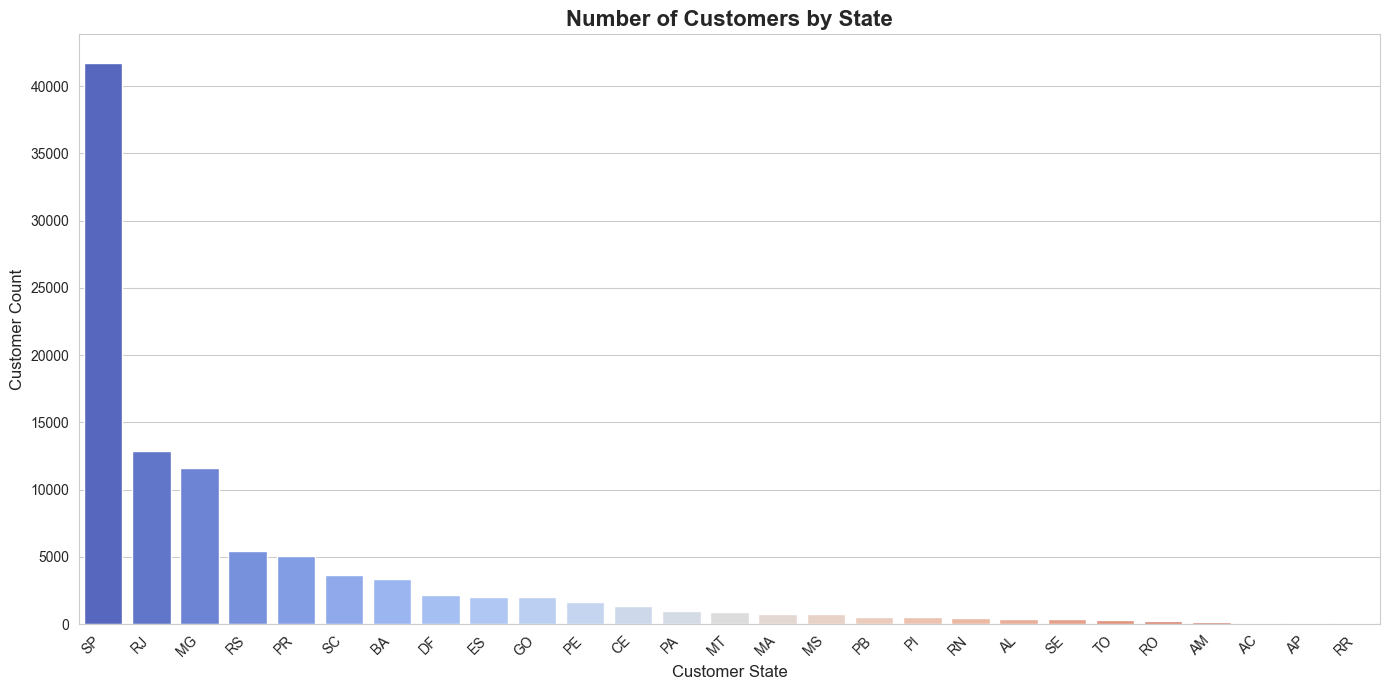

In [8]:
# we have only 26 rows data so we can visualize it

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# sorting for easy visualization
df_sorted = df.sort_values("Customer Count",ascending=False)

ax = sns.barplot(
    x='Customer State',
    y='Customer Count',
    data=df_sorted,
    palette='coolwarm'  
)

# Titles and labels
plt.title("Number of Customers by State", fontsize=16, fontweight='bold')
plt.xlabel("Customer State", fontsize=12)
plt.ylabel("Customer Count", fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Intermediate Queries


## 1. Calculate the number of orders per month in 2018.


In [9]:
query = """SELECT MONTHNAME(order_purchase_timestamp) AS Order_Month,
COUNT(order_id) FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY Order_Month , MONTH(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp);
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Order Month","Order Count"])
df

,Order Month,Order Count
0,January,7269
1,February,6728
2,March,7211
3,April,6939
4,May,6873
5,June,6167
6,July,6292
7,August,6512
8,September,16
9,October,4


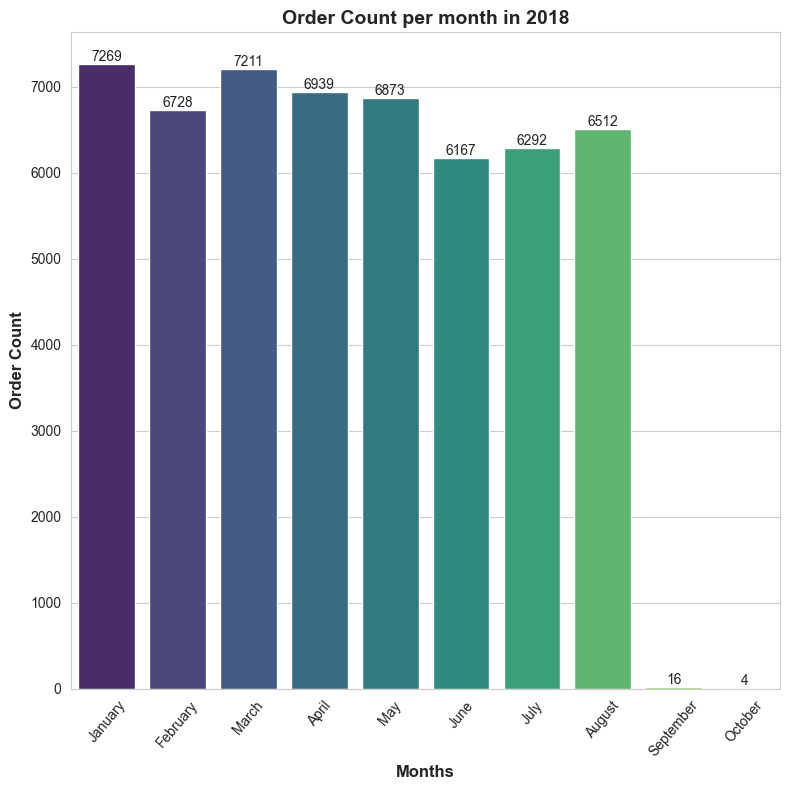

In [12]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x=df["Order Month"],y=df["Order Count"],data=df,palette="viridis")

plt.title("Order Count per month in 2018", fontsize=14, fontweight='bold')
plt.xlabel("Months", fontsize=12, fontweight='bold')
plt.ylabel("Order Count", fontsize=12, fontweight='bold')

ax.bar_label(ax.containers[0])
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

## 2. Find the average number of products per order, grouped by customer city.


In [13]:
query = """
WITH count_per_order AS (
SELECT o.order_id,o.customer_id,COUNT(oi.product_id) as oc
FROM orders AS o
JOIN order_items as oi
ON o.order_id = oi.order_id
GROUP BY o.order_id,o.customer_id
)
SELECT c.customer_city,AVG(count_per_order.oc) as Average_Orders
FROM customers c
JOIN count_per_order
ON c.customer_id = count_per_order.customer_id
GROUP BY c.customer_city
ORDER BY Average_Orders DESC;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Customer City","Average Order Count"])
df

,Customer City,Average Order Count
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,candido godoi,6.0000
3,datas,6.0000
4,matias olimpio,5.0000
...,...,...
4105,sebastiao leal,1.0000
4106,morro agudo de goias,1.0000
4107,santa filomena,1.0000
4108,guamiranga,1.0000


## 3. Calculate the percentage of total revenue contributed by each product category.


In [15]:
query = """
WITH revenue_by_category AS (
SELECT coalesce(p.product_category,'Uncategorised') AS Product_Category,
ROUND(SUM(oi.price+oi.freight_value),2) AS revenue
FROM order_items oi
JOIN products p
ON oi.product_id = p.product_id
GROUP BY coalesce(p.product_category,'Uncategorised')
)
SELECT revenue_by_category.Product_Category AS Prod_Category,
ROUND((revenue_by_category.revenue / total.total_revenue)*100,2) 
AS Percentage_Of_TotalRevenue_Per_Category
FROM revenue_by_category,
(SELECT SUM(revenue) AS total_revenue FROM revenue_by_category) AS total
ORDER BY Percentage_Of_TotalRevenue_Per_Category DESC;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Product Category","Percentage of total revenue"])
df


,Product Category,Percentage of total revenue
0,HEALTH BEAUTY,9.10
1,Watches present,8.24
2,bed table bath,7.84
3,sport leisure,7.30
4,computer accessories,6.69
...,...,...
69,flowers,0.01
70,House Comfort 2,0.01
71,cds music dvds,0.01
72,Fashion Children's Clothing,0.00


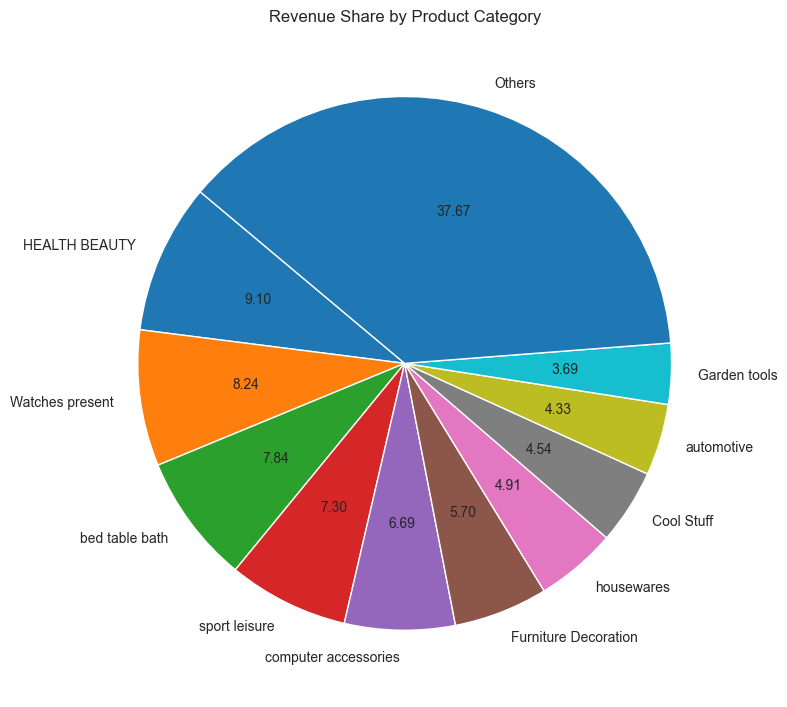

In [17]:
# to visualize this much big data , we keep top 10 data and rest as Others
topn = 10
df_top = df.iloc[:topn].copy()

others = df["Percentage of total revenue"].iloc[topn:].sum()
df_top.loc[len(df_top.index)] = ['Others',round(others,2)]

plt.figure(figsize=(8,8))
plt.pie(df_top['Percentage of total revenue'],labels=df_top['Product Category'],autopct="%.2f",startangle=140)

plt.title("Revenue Share by Product Category",fontsize=12)
plt.tight_layout()
plt.show()

## 4. Identify the correlation between product price and the number of times a product has been purchased.


In [23]:
query = """
SELECT upper(p.product_category),COUNT(oi.product_id) AS Product_Order_Count,
ROUND(AVG(oi.price),2) as Average_Product_Price
FROM products p
JOIN order_items oi
ON p.product_id = oi.product_id
GROUP BY p.product_category
ORDER BY Product_Order_Count DESC;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Product Category","Product Order Count","Average Product Price"])
df


,Product Category,Product Order Count,Average Product Price
0,BED TABLE BATH,11115,93.30
1,HEALTH BEAUTY,9670,130.16
2,SPORT LEISURE,8641,114.34
3,FURNITURE DECORATION,8334,87.56
4,COMPUTER ACCESSORIES,7827,116.51
...,...,...,...
69,LA CUISINE,14,146.78
70,CDS MUSIC DVDS,14,52.14
71,PC GAMER,9,171.77
72,FASHION CHILDREN'S CLOTHING,8,71.23


In [ ]:
# to get the correlation b/w count and price
arr1 = df['Product Order Count']
arr2 = df['Average Product Price']

np.corrcoef(arr1,arr2)

# here the correlation is neutral : means there's no such relation if order count increase then price change or something

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

## 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [25]:
query = """
SELECT *, DENSE_RANK() OVER( ORDER BY total_sales DESC) AS ranking
FROM
(SELECT oi.seller_id, SUM(p.payment_value) as total_sales
FROM order_items oi
JOIN payments p
ON oi.order_id = p.order_id
GROUP BY oi.seller_id) AS b;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Seller Id","Sales","Ranking"])
df


,Seller Id,Sales,Ranking
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


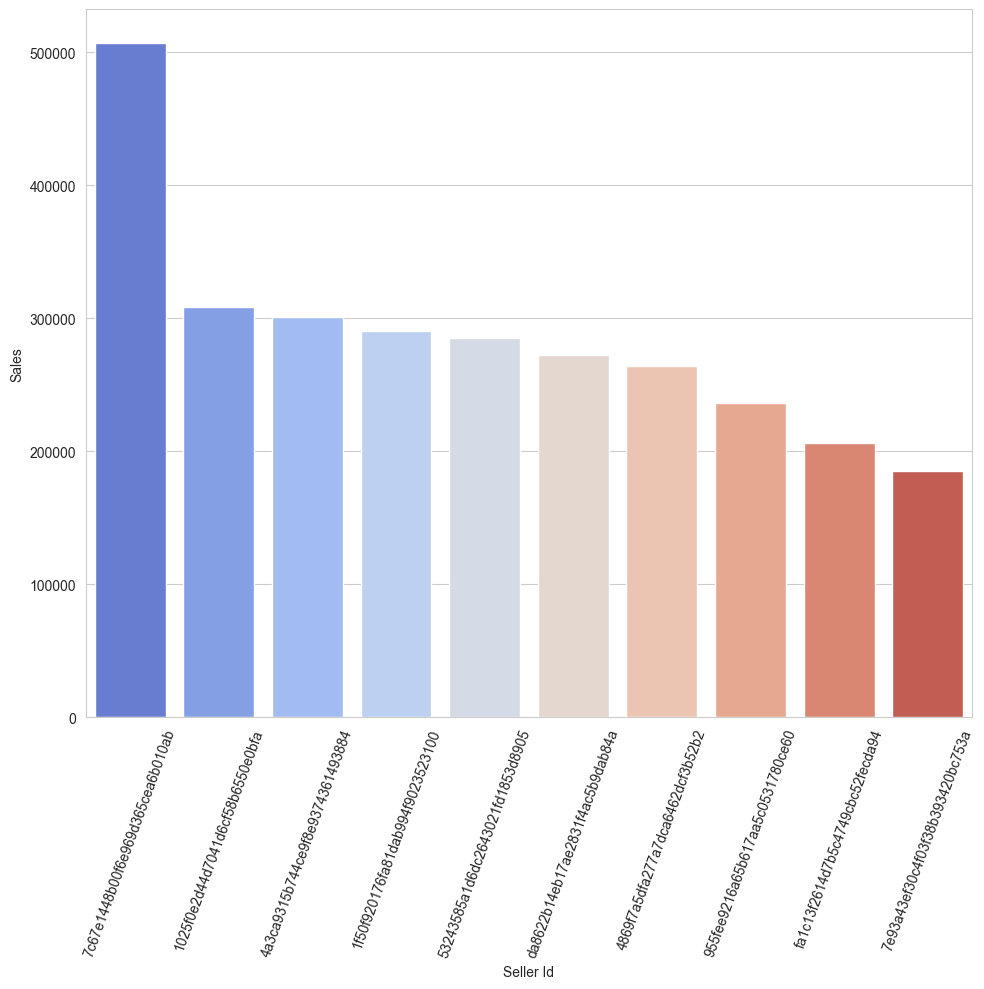

In [27]:
plt.figure(figsize=(10,10))
sns.barplot(x="Seller Id",y="Sales",data = df.head(10),palette="coolwarm")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

# Advanced Queries

## 1. Calculate the moving average of order values for each customer over their order history.


In [30]:
query = """
SELECT 
  o.customer_id,
  o.order_id,
  o.order_purchase_timestamp,
  SUM(p.payment_value) AS order_value,
  
  AVG(SUM(p.payment_value)) OVER (
    PARTITION BY o.customer_id
    ORDER BY o.order_purchase_timestamp
    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  ) AS moving_avg
  
FROM orders o
JOIN payments p ON o.order_id = p.order_id
GROUP BY o.customer_id, o.order_id, o.order_purchase_timestamp
ORDER BY o.customer_id, o.order_purchase_timestamp;

"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Customer Id","Order Id","Order Time","Order Value","Moving Average"])
df


,Customer Id,Order Id,Order Time,Order Value,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,2017-11-14 16:08:26,114.739998,114.739998
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,2017-07-16 09:40:32,67.410004,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,2017-02-28 11:06:43,195.419998,195.419998
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,2017-08-16 13:09:20,179.350006,179.350006
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,2018-04-02 13:42:17,107.010002,107.010002
...,...,...,...,...,...
99435,fffecc9f79fd8c764f843e9951b11341,814d6a3a7c0b32b2ad929ac6328124e9,2018-03-29 16:59:26,81.360003,81.360003
99436,fffeda5b6d849fbd39689bb92087f431,8c855550908247a7eff50281b92167a8,2018-05-22 13:36:02,63.130001,63.130001
99437,ffff42319e9b2d713724ae527742af25,83b5fc912b2862c5046555ded1483ae9,2018-06-13 16:57:05,214.130005,214.130005
99438,ffffa3172527f765de70084a7e53aae8,d0e7be325a1c986babc4e1cdb91edc03,2017-09-02 11:53:32,45.500000,45.500000


## 2. Calculate the cumulative sales per month for each year.


In [31]:
query = """
select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns=["Year","Month","Payment","Cumulative Payment"])
df


,Year,Month,Payment,Cumulative Payment
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


## 3. Calculate the year-over-year growth rate of total sales.

In [32]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


## 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [33]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

((None,),)

## 5. Identify the top 3 customers who spent the most money in each year.

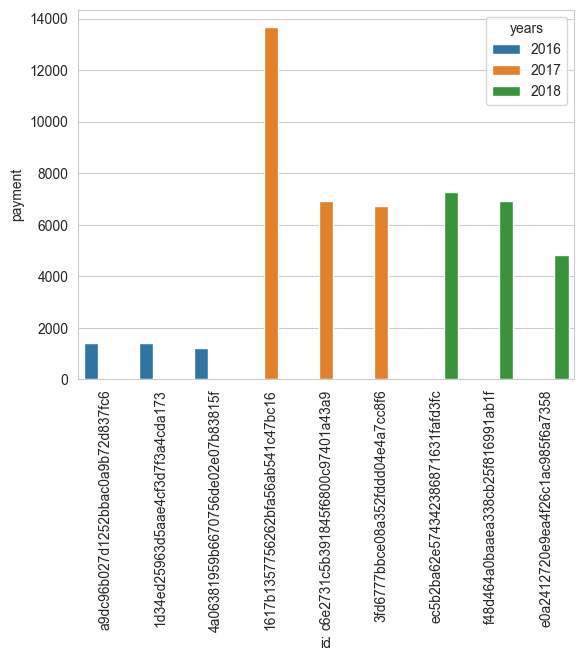

In [34]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()